[![Open In Colab](./colab-badge.png)](https://colab.research.google.com/github/MooseNeuro/moose-notebooks/blob/main/Synapses.ipynb) [![Binder](./binder_logo.png)](https://mybinder.org/v2/gh/MooseNeuro/moose-notebooks/HEAD?labpath=Synapses.ipynb)

In [2]:
## Only required on colab! Uncomment to enable.
# !pip install pymoose --quiet

# Synaptic connections

Neurons communicate with one another as well as nearby cells of other kind, like glia, at multiple time scales. When we are looking at very short time scales, like milliseconds to seconds, this communication promarily happens via connections called synapses.

There are two primary types of such connections: electrical and chemical synapses. Electrical synapses are also called *gap junctions*. At these junction the cell membranes of two neurons fuse together via channels made of protein molecules called *connexin* (*innexin* in insects), creating continuity of their cytoplasm. Electrical changes in one neuron directly flow into the connected neighbour and evoke corresponding changes there.

The other type of synapses do not involve direct connection, and there is a small gap of about 20-40 nm between the terminals of two neurons. Synapses occur between two axons (axo-axonic), two dendrites (dendro-denritic), axon and soma (axo-somatic), dendrite and soma (dendro-somatic). But synapses between axon terminal of one neuron (presynaptic) and dendrites of another (postsynaptic) is the simplest to start with. These are called axo-dendritic synapses.

A presynaptic terminal stores special chemicals in little sack-like structures called vesicles. When the terminal is depolarized, for example due to an action potential, vesicles fuse with the cell membrane and release its chemical (called neurotransmitter) into the synaptic cleft. The molecules of the neurotransmitter diffuses through the cleft and attaches to receptor molecules on cellmembrane on the postsynaptic terminal. 

The receptor molecule may be a channel itself, and get opened when the neurotransmitter molecule bonds with it (like key opening a lock). Then based on what ions the receptor channel allows to flow, and electrochemical gradients of those ions, current can flow into or out of the postsynaptic terminal.

If positive ions flow in, they increase (depolarize) the membrane voltage of the postsynaptic terminal. In current clamp experiments the positive blip (depolarization) in the membrane voltage is called excitatory post synaptic potential (EPSP). There several mathematical models of the EPSP time-course that provide good approximations experimental results. 

A simple one is called the $\alpha$ synapse. Like Hodgkin-Huxley type channels, here also we model the condutance of the synptic channel as a function of time (unlike HH channels it does not depend on the voltage).

$g(t) = g_{max}\ \frac{t}{\tau}\ e^{-t/\tau}$

Here $g(t)$ is the coductance at $t$ time after onset (when the channel is turned on). $g_{max}$ is the peak conductance of the synapse. This function is called the $\alpha$ function and hence the name of the model. We can easily compute and plot this using nunmpy and matplotlib.


Text(0.5, 0.98, 'alpha synapse time course')

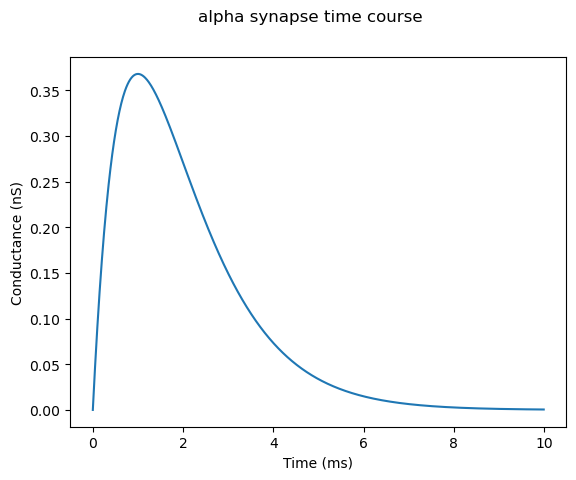

In [3]:
# plot the conductance of an alpha synapse over time from onset
import numpy as np
import matplotlib.pyplot as plt


t = np.arange(0, 10.0, 1e-2)   # time points in ms
gmax = 1.0   # arbitrarily setting to, say 1 nS
tau = 1.0   # ms

g = gmax * (t / tau) * np.exp(- t / tau)

plt.plot(t, g)
plt.xlabel('Time (ms)')
plt.ylabel('Conductance (nS)')
plt.suptitle('alpha synapse time course')


# Simulating a synapse with moose

 [<img src="synchan.svg" width="400"/>](SynChan)

*Figure: Components of a synapse in moose. `SpikeGen` objects (yellow circles) monitor presynaptic terminals (compartments) for threshold crossing. Each `SpikeGen` is mapped to a `synapse` (black bars) in a `SynHandler`(dark cyan). The events then evoke changes in conductance (`Gk`) of the `SynChan` objects (light purple).*

In a simulation we treat the presynaptic spike as an event in time, and this triggers the synapse to go through this conductance change. The synaptic channel is implemented by the `SynChan` class. The presynaptic event is delivered by a class called `SpikeGen` (for spike generator). Like HHChannels, this too has the `Gbar` field for the maximum conductance and `Gk` for the computed conductance. The reversal potential `Ek` determines whether activation of the channel would depolarize or hyperpolarize the compartmemnt.

In [4]:
import moose


# This is a safety check in case we run the same code repeatedly
if moose.exists('/sim'):
    moose.delete('/sim')

container = moose.Neutral('/sim')
model = moose.Neutral(f'{container.path}/model')
data = moose.Neutral(f'{container.path}/data')

# build a compartment to embed the synapse on
comp = moose.Compartment(f'{model.path}/comp')
vtab = moose.Table(f'{data.path}/Vm')
moose.connect(vtab, 'requestOut', comp, 'getVm')

<moose.SingleMsg id=5 dataIndex=0 path=/Msgs[0]/singleMsg[0]>

In [5]:
# Create and connect the synaptic channel
synchan = moose.SynChan(f'{comp.path}/synchan')

gtab = moose.Table(f'{data.path}/gsyn')  # for recording the conductance

# Like HHChannel SynChan also is connected by `channel` message with the compartment
moose.connect(synchan, 'channel', comp, 'channel')
moose.connect(gtab, 'requestOut', synchan, 'getGk')

<moose.SingleMsg id=5 dataIndex=2 path=/Msgs[0]/singleMsg[2]>

To allow for more complex synaptic dynamics, like synaptic plasticity moose implements a synapse with multiple components. The `SynChan` handles the channel conductance, and another class, `SynHandler`, handles the incoming spike events.

In [6]:
synh = moose.SimpleSynHandler(f'{synchan.path}/synh')
# A SynHandler can handle multiple incoming synaptic terminals.
# By setting numSynapses = 1, we set the number of synapse elements 
# under the SynHandler
synh.numSynapses = 1
moose.connect(synh, 'activationOut', synchan, 'activation')

<moose.SingleMsg id=5 dataIndex=3 path=/Msgs[0]/singleMsg[3]>

In [7]:
# Create and connect a spike generator to deliver spike events to the `SynChan`
spikegen = moose.SpikeGen(f'{synchan.path}/spike')

moose.connect(spikegen, 'spikeOut', synh.synapse[0], 'addSpike')

<moose.SingleMsg id=5 dataIndex=4 path=/Msgs[0]/singleMsg[4]>

`SpikeGen` objects detect the threshold crossing events on the presynaptic side and transmit the event time to the synapse under the `SynHandler`. In complete neuronal network models it would sense this from the presynaptic `Compartment`. For now we shall use a `PulseGen` object to provide this threshold-crossing event.

In [8]:
pulse = moose.PulseGen(f'{model.path}/pulse')
moose.connect(pulse, 'output', spikegen, 'Vm')

pulsetab = moose.Table(f'{data.path}/pulse')
moose.connect(pulsetab, 'requestOut', pulse, 'getOutputValue')

<moose.SingleMsg id=5 dataIndex=6 path=/Msgs[0]/singleMsg[6]>

Now we setup the `PulseGen` to generate a single step, and set the threshold for the `SpikeGen` to half of that value.

In [9]:
pulse.delay[0] = 5e-3   # 10 ms
pulse.level[0] = 1.0
pulse.width[0] = 1e9

spikegen.threshold = 0.5

## Set the compartment properties

In [10]:
comp.Cm = 1e-12
comp.Rm = 1e7
comp.Em = -70e-3
comp.initVm = -70e-3

## Set the synapse properties
Now the most important part, setting the properties of the synapse. `SynChan` in moose allows two time constants for a more general model of synaptic conductance. If we make these two time constants identical then the dynamics turns into that of an alpha synapse.

In [11]:
synh.synapse[0].weight = 1.0
synh.synapse[0].delay = 1e-3   # 1 ms synaptic delay

synchan.Ek = 0.0      # reversal potential
synchan.Gbar = 1e-6   # 1 uS
synchan.tau1 = 1e-3  # 1 ms time constant
synchan.tau2 = 1e-3    # tau1 = tau2 makes it an alpha synapse

## Reset and run the simulation

In [12]:
runtime = 30e-3

moose.reinit()
moose.start(runtime)


## Synaptic current

Like the variable conductance model of $Na^{+}$ and $K^{+}$ channels, synaptic conductances are also modeled as variable conductance in parallel with the leak resistance. The current through the synaptic channel at any time can be computed using Ohm's law.


$I_{k} = G_{k}\ (E_{k} - V_{m})$

In python:

In [13]:
Ik = gtab.vector * (synchan.Ek - vtab.vector)

# Plot the Vm and the Gk

Text(0.5, 0, 'time (ms)')

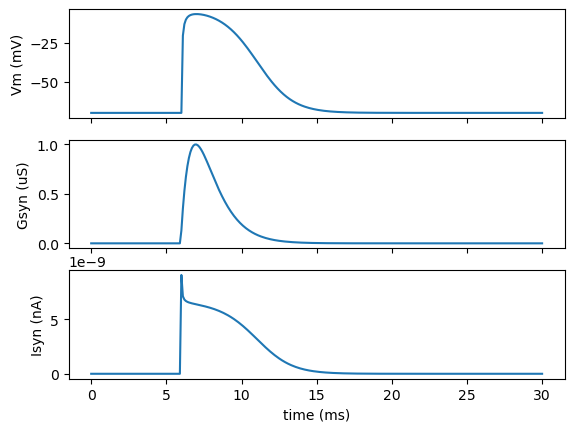

In [14]:
fig, axes = plt.subplots(nrows=3, sharex='all')
t = np.arange(len(vtab.vector)) * vtab.dt * 1e3
axes[0].plot(t, vtab.vector * 1e3)
axes[0].set_ylabel('Vm (mV)')
axes[1].plot(t, gtab.vector * 1e6)
axes[1].set_ylabel('Gsyn (uS)')
axes[2].plot(t, Ik)
axes[2].set_ylabel('Isyn (nA)')
axes[2].set_xlabel('time (ms)')


## Points to note
1. We had set the synaptic delay to 1 ms. Therefore although our pulsegen's `delay[0]` was set to 5 ms, the change in the synaptic conductance (and the compartment voltage) starts at 6 ms.
2. The compartment voltage has a slower time course than the synaptic conductance. This is because the parallel RC circuit of the passive compartment works as a low pass filter, smoothing out fast changes.

# Exercise

1. Change the reversal potential of the `SynChan` to -90 mV and run the simulation again. What do you observe in the plots?
2. Change the value of `weight` field of `synapse[0]` in the `SynHandler` (`synh.synapse[0].weight`) to 0.5 and rerun the simulation. How does the `Gk` change compared to the original model?
3. Setting the `PulseGen` object's `width[0]` to a very large number ensures that it steps up to the value `level[0]` and does not come down during the simulation. Refer to the [More_complex_current_injection_protocol](./More_complex_current_injection_protocol.ipynb) notebook to review `PulseGen`. Update the properties (possibly `delay[0]`, `width[0]`, `delay[1]`, `width[1]`, `level[1]`) of the `PulseGen` object to deliver two pulses  (and hence spikes from the connected `SpikeGen` object) in quick succession. Vary the interval between these two pulses and note what you observe in the post-synaptic voltage.